In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.svm import OneClassSVM
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import TomekLinks
from sklearn.utils.class_weight import compute_class_weight

In [16]:
data = pd.read_csv('data/sim_with_razor_extended.csv')
data = data.dropna()
data = data.drop('Event Number', axis=1)

In [17]:
X = data.drop('Dark Photon Produced', axis=1)
y = data['Dark Photon Produced'].astype(int)  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
tomek_links = TomekLinks()
adasyn = ADASYN(random_state=42)

pipeline = Pipeline([
    ('adasyn', adasyn),
    ('tomek', tomek_links)
])

X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

In [20]:

model = Sequential()
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(BatchNormalization())  # Add batch normalization
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())  # Add batch normalization
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())  # Add batch normalization

model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_resampled)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# 4. Model Training
history = model.fit(X_train_scaled, y_resampled, epochs=50, batch_size=32, validation_split=0.2, class_weight=class_weights_dict)

Epoch 1/50
19999/19999 ━━━━━━━━━━━━━━━━━━━━ 15s 707us/step - accuracy: 0.9303 - loss: 0.1845 - val_accuracy: 0.7853 - val_loss: 0.7103
Epoch 2/50
19999/19999 ━━━━━━━━━━━━━━━━━━━━ 16s 776us/step - accuracy: 0.9763 - loss: 0.0798 - val_accuracy: 0.8978 - val_loss: 0.4762
Epoch 3/50
19999/19999 ━━━━━━━━━━━━━━━━━━━━ 15s 732us/step - accuracy: 0.9800 - loss: 0.0685 - val_accuracy: 0.9106 - val_loss: 0.5706
Epoch 4/50
19999/19999 ━━━━━━━━━━━━━━━━━━━━ 13s 638us/step - accuracy: 0.9823 - loss: 0.0606 - val_accuracy: 0.8492 - val_loss: 0.7809
Epoch 5/50
19999/19999 ━━━━━━━━━━━━━━━━━━━━ 15s 764us/step - accuracy: 0.9840 - loss: 0.0556 - val_accuracy: 0.9020 - val_loss: 0.6347
Epoch 6/50
19999/19999 ━━━━━━━━━━━━━━━━━━━━ 13s 659us/step - accuracy: 0.9844 - loss: 0.0550 - val_accuracy: 0.9093 - val_loss: 0.4481
Epoch 7/50
19999/19999 ━━━━━━━━━━━━━━━━━━━━ 14s 696us/step - accuracy: 0.9860 - loss: 0.0506 - val_accuracy: 0.9043 - val_loss: 0.4752
Epoch 8/50
19999/19999 ━━━━━━━━━━━━━━━━━━━━ 13s 650us/s

In [25]:
y_prob_nn = model.predict(X_test_scaled).ravel()
y_pred_nn = (y_prob_nn > 0.5).astype(int)

# Confusion matrix and classification report
conf_matrix_nn = confusion_matrix(y_test, y_pred_nn)
class_report_nn = classification_report(y_test, y_pred_nn)
print("Confusion Matrix (Neural Network):\n", conf_matrix_nn)
print("Classification Report (Neural Network):\n", class_report_nn)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 277us/step
Confusion Matrix (Neural Network):
 [[99740   255]
 [    5     0]]
Classification Report (Neural Network):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     99995
           1       0.00      0.00      0.00         5

    accuracy                           1.00    100000
   macro avg       0.50      0.50      0.50    100000
weighted avg       1.00      1.00      1.00    100000



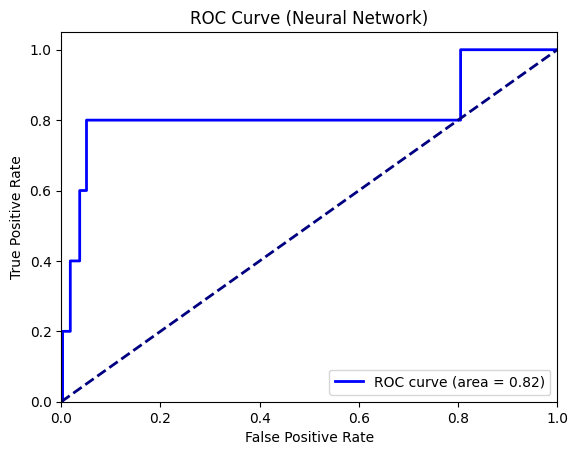

In [26]:
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_prob_nn)
roc_auc_nn = auc(fpr_nn, tpr_nn)

plt.figure()
plt.plot(fpr_nn, tpr_nn, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_nn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Neural Network)')
plt.legend(loc="lower right")
plt.show()

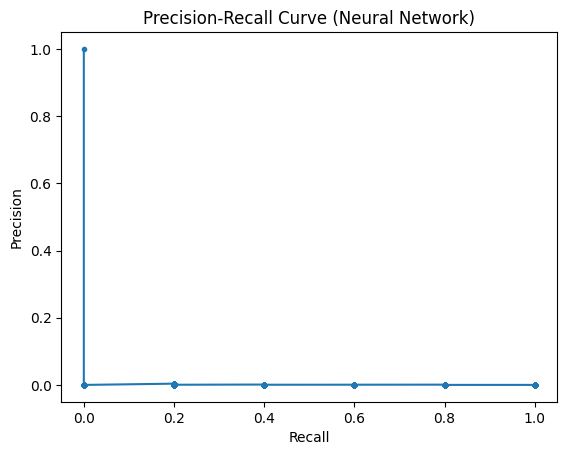

In [27]:
# Precision-Recall Curve for Neural Network
precision_nn, recall_nn, thresholds_nn = precision_recall_curve(y_test, y_prob_nn)

plt.plot(recall_nn, precision_nn, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Neural Network)')
plt.show()